In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
from scipy.io import loadmat
from pathlib import Path
import matplotlib.patches as patches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
# the following import is required for matplotlib < 3.2:
from mpl_toolkits.mplot3d import Axes3D  # noqa
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_rel
from scipy.signal import butter, filtfilt
import mne
import eeg_analysis.funcs4eeg as fe
import re
import imp
import ast
import behavior.func4behav as fb
imp.reload(fe)
imp.reload(fb)
import matplotlib

from scipy import signal
from scipy.signal import resample
from scipy.ndimage import zoom

### for endo or exo

In [2]:
def align_slow(eeg, case, fs):
    if 'endo' in case:
        jump_from, jump_to = int((1.5+1+0.5)*fs), int((1.5+1+1)*fs)
    elif 'exo' in case:
        jump_from, jump_to = int((1.5+0.033*4+0.5)*fs), int((1.5+0.033*4+1)*fs)
    
    for channel in range(len(eeg)):
        eeg[channel] = np.concatenate((eeg[channel][:,:jump_from], eeg[channel][:,jump_to:]), axis=1)
        
    return eeg

case_title = 'exo' # switch 'endo' or 'exo' HERE!
case_list = [case_title+' fast', case_title+' slow']
if 'endo' in case_title:
    tmax_list = [1.5+1+0.5+0.05+0.2, 1.5+1+1+0.05+0.2]
else:
    tmax_list = [1.5+0.033*4+0.5+0.05+0.2, 1.5+0.033*4+1+0.05+0.2]

fs = 1200
for i, case in enumerate(case_list):
    tmax = tmax_list[i]
    watch = '1 fixation'
    tmin = 0 # include fix or not?

    highpass = None
    lowpass = None

    sb, sa, rb, ra = fe.pipeline_bpdata_channel(case, watch, tmin, tmax, hipass=highpass, lopass=lowpass, baseline=(0,0), detrend=1)
    
    if 'slow' in case:
        # sham_before_slow = align_slow(sb, case, fs)
        # sham_after_slow = align_slow(sa, case, fs)
        # real_before_slow = align_slow(rb, case, fs)
        # real_after_slow = align_slow(ra, case, fs)

        sham_before_slow = sb
        sham_after_slow = sa
        real_before_slow = rb
        real_after_slow = ra

    else:
        sham_before_fast = sb
        sham_after_fast = sa
        real_before_fast = rb
        real_after_fast = ra

c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tACS-Attention\processing\behavior\func4behav.py:158: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  behavior_compare = pd.concat([behavior_compare, new_row], ignore_index=True)
c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tACS-Attention\processing\behavior\func4behav.py:158: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  behavior_compare = pd.concat([behavio

In [3]:
freq_bands = [[4, 8], [8, 12], [12, 30], [30, 46]]
# exclude fixation
endo_fast_interval = [1.5+1, 1.5+1+0.5]
# endo_slow_interval = [1.5+1, 1.5+1+0.5+0.05+0.2]
endo_slow_interval = [1.5+1, 1.5+1+1]
exo_fast_interval = [1.5+0.033*4, 1.5+0.033*4+0.5]
# exo_slow_interval = [1.5+0.033*4, 1.5+0.033*4+0.5]
exo_slow_interval = [1.5+0.033*4, 1.5+0.033*4+1]

if 'endo' in case_title:
    intervals = [endo_fast_interval, endo_slow_interval]
else:
    intervals = [exo_fast_interval, exo_slow_interval]

origin_slow_sessions = [sham_before_slow, sham_after_slow, real_before_slow, real_after_slow] # 4 sessions * y subjects * (z trials * 32 channels * timepoints)
origin_fast_sessions = [sham_before_fast, sham_after_fast, real_before_fast, real_after_fast]

In [4]:
slow_sessions, fast_sessions = [None]*4, [None]*4
for i, session in enumerate(origin_slow_sessions): # session in shape: y subjects * (z trials * 32 channels * timepoints)
    tmp = session[0] # tmp in shape: z trials * 32 channels * timepoints
    for j in range (1, len(session)):
        tmp = np.concatenate((tmp, session[i])) # session[i] in shape: z trials * 32 channels * timepoints
    slow_sessions[i] = tmp

for i, session in enumerate(origin_fast_sessions):
    tmp = session[0]
    for j in range (1, len(session)):
        tmp = np.concatenate((tmp, session[i]))
    fast_sessions[i] = tmp

# times 1e6
for i in range(4):
    slow_sessions[i] = slow_sessions[i] * 1e6
    fast_sessions[i] = fast_sessions[i] * 1e6

print(slow_sessions[0].shape, slow_sessions[1].shape, slow_sessions[2].shape, slow_sessions[3].shape)
print(fast_sessions[0].shape, fast_sessions[1].shape, fast_sessions[2].shape, fast_sessions[3].shape)
# 2.2s

(189, 32, 3459) (269, 32, 3459) (245, 32, 3459) (231, 32, 3459)
(175, 32, 2859) (268, 32, 2859) (254, 32, 2859) (233, 32, 2859)


In [5]:
alpha_data = [np.empty(()),np.empty(()),np.empty(()),np.empty(())] # 4 sessions, xx trials, 32 channels
count = 0
for i in range(4):
    fast_session = fast_sessions[i]
    slow_session = slow_sessions[i]
    one_session = np.empty((fast_sessions[i].shape[0]+slow_sessions[i].shape[0],32))
    # print(one_session.shape)
    for j, data in enumerate([fast_session, slow_session]): # data: trials x channels x time
        interval = intervals[j]
        t_start, t_end = int(interval[0]*fs), int(interval[1]*fs)
        trial_count = j*fast_session.shape[0]-1
        for trial in range(data.shape[0]):
            trial_count += 1
            one_trial = np.empty((32))  
            for channel in range(32):
                # print('session:', i, 'trial:', trial_count, 'channel:', channel)
                one_trial[channel] = fe.dfa_alpha(data[trial,channel,t_start:t_end])
            # print(trial_count)
            one_session[trial_count,:] = one_trial # one_session[trial_count,:,:] in shape: 32 channels
    alpha_data[i] = one_session

print(count)
# 9m 57.2s

0


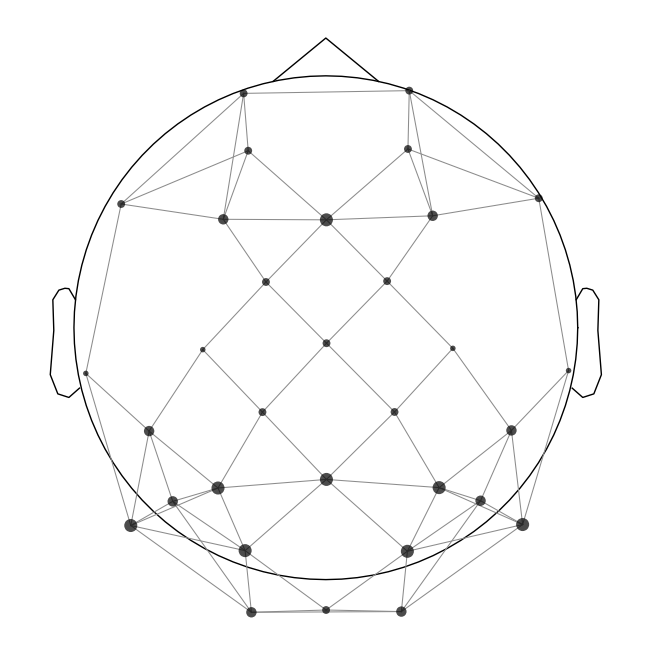

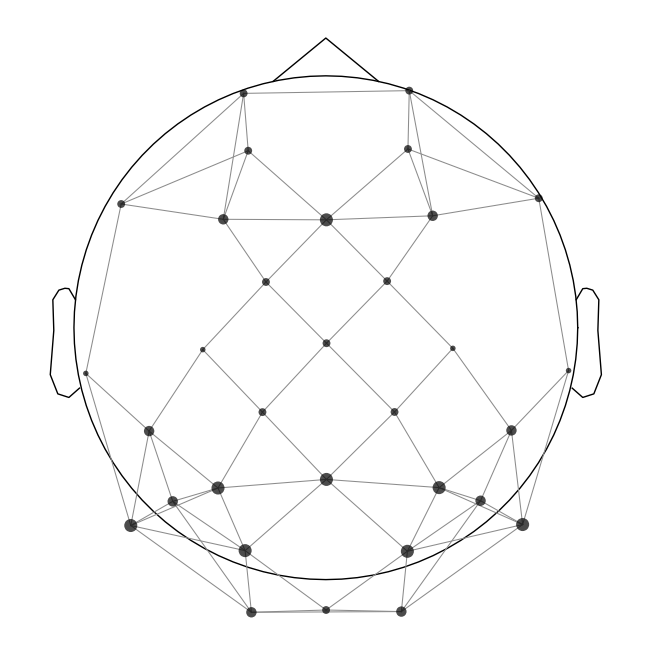

In [6]:
from scipy.sparse import csr_matrix
from scipy.spatial import distance_matrix

def compute_adjacency():
    eeg_data = np.zeros((32, 2))
    # get placement data of standard 10-20 system
    montage_1020 = mne.channels.make_standard_montage('standard_1020')
    positions_1020 = montage_1020._get_ch_pos()
    ch_names = ['Fp1', 'Fp2', 'AF3', 'AF4', 'F7', 'F3', 'Fz', 'F4', 'F8',
                'FC1', 'FC2', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP5', 'CP1', 
                'CP2', 'CP6', 'P7', 'P5', 'P3', 'Pz', 'P4', 'P6', 'P8',
                'PO3', 'PO4', 'O1', 'Oz', 'O2']
    ch_types = ['eeg'] * 32
    info = mne.create_info(ch_names, sfreq=1200, ch_types=ch_types, verbose=False)
    raw = mne.io.RawArray(eeg_data, info, verbose=False)

    elec_coords = {ch: positions_1020[ch] for ch in ch_names}
    montage = mne.channels.make_dig_montage(elec_coords, coord_frame='head')
    raw.set_montage(montage)
    
    # Extract the 3D coordinates
    pos = np.stack([raw.info['dig'][i]['r'] for i in range(len(raw.info['dig'])) if raw.info['dig'][i]['kind'] == mne.io.constants.FIFF.FIFFV_POINT_EEG])
    
    # Calculate the distance matrix
    dist_matrix = distance_matrix(pos, pos)
    
    # Define adjacency based on distance threshold
    threshold = np.percentile(dist_matrix, 17.5)  # !!!!! 17.5th percentile of distances as threshold
    adjacency_matrix = dist_matrix < threshold
    
    return adjacency_matrix


ch_names = ['Fp1', 'Fp2', 'AF3', 'AF4', 'F7', 'F3', 'Fz', 'F4', 'F8',
                'FC1', 'FC2', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP5', 'CP1', 
                'CP2', 'CP6', 'P7', 'P5', 'P3', 'Pz', 'P4', 'P6', 'P8',
                'PO3', 'PO4', 'O1', 'Oz', 'O2']
raw = fe.channel_pos()
adjacency_ndarray = compute_adjacency()
adjacency = csr_matrix(adjacency_ndarray)
mne.viz.plot_ch_adjacency(raw.info, adjacency, ch_names)


Comparison: pre-sham vs. pre-active


c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tACS-Attention\processing\eeg_analysis\funcs4eeg.py:1253: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  f_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Cluster 0, p-value: 0.0005
Electrodes: [ 1  3  7  8 10 13 14 15 18 19 21 22 23 24 25 26 27 28 29 30 31]

Comparison: pre-sham vs. post-sham


c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tACS-Attention\processing\eeg_analysis\funcs4eeg.py:1253: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  f_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Cluster 0, p-value: 0.0005
Electrodes: [ 0  1  3  5  6  7  8  9 10 11 14 15 18 20 21 22 23 24 25 26 28 29 31]

Comparison: pre-active vs. post-active


c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tACS-Attention\processing\eeg_analysis\funcs4eeg.py:1253: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  f_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Cluster 0, p-value: 0.0005
Electrodes: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]


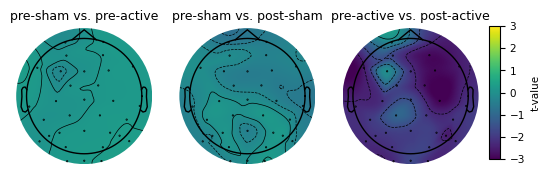

In [8]:
def shuffle12(condition1, condition2, ratio):
    # Determine the number of rows to swap for each condition
    num_to_swap_condition1 = int(ratio * condition1.shape[0])
    num_to_swap_condition2 = int(ratio * condition2.shape[0])
    
    # Step 1: Randomly select rows to swap from each condition
    rows_to_swap_condition1 = np.random.choice(condition1.shape[0], num_to_swap_condition1, replace=False)
    rows_to_swap_condition2 = np.random.choice(condition2.shape[0], num_to_swap_condition2, replace=False)
    
    # Step 2: Create copies of the conditions to modify
    new_condition1 = np.copy(condition1)
    new_condition2 = np.copy(condition2)
    
    # Step 3: Swap the rows between conditions
    # Temporary storage for swapping
    temp = new_condition1[rows_to_swap_condition1].copy()
    new_condition1[rows_to_swap_condition1] = new_condition2[rows_to_swap_condition2][:num_to_swap_condition1]
    new_condition2[rows_to_swap_condition2][:num_to_swap_condition1] = temp[:num_to_swap_condition2]
    
    return new_condition1, new_condition2


def normalize_t_obs(t_obs): # t_obs in shape: 3 comparisons * 32 channels
    # Step 1: Find the maximum absolute value
    max_abs_value = np.max(np.abs(t_obs))
    
    # Step 2: Normalize the array
    normalized_t_obs = (t_obs / max_abs_value) * 3
    
    return normalized_t_obs


band_names = ['theta', 'alpha', 'beta', 'gamma']
comparisons = [[0, 2], [0, 1], [2, 3]]
# comparison_names = ['pre-sham\nvs.\npre-active', 'pre-sham\nvs.\npost-sham', 'pre-active\nvs.\npost-active']
comparison_names = ['pre-sham vs. pre-active', 'pre-sham vs. post-sham', 'pre-active vs. post-active']

t_obs = np.zeros((3, 32))

cm = 1/2.54

for j, comparison in enumerate(comparisons):
    condition1 = alpha_data[comparison[0]]
    condition2 = alpha_data[comparison[1]]
    if j == 0: # pre-sham vs. pre-active
        condition1, condition2 = shuffle12(condition1, condition2, ratio = 0.8)
    elif j == 1:
        condition1, condition2 = shuffle12(condition1, condition2, ratio = 0.3)
    print(f"\nComparison: {comparison_names[j]}")
    t_obs[j,:] = fe.perm_test(condition1, condition2, adjacency)    
    
normalized_t = normalize_t_obs(t_obs)
fig, axes = plt.subplots(nrows=1, ncols=len(comparison_names), figsize=(4.5*3*cm, 4.5*cm))
for j in range(len(comparison_names)):
    ax = axes[j]  # Get the correct axis from the grid
    im, cn = mne.viz.plot_topomap(normalized_t[j,:], pos=raw.info, axes=ax, show=False, contours=4, vlim=[-3, 3], cmap='viridis')
    # Add title to each subplot
    ax.set_title(comparison_names[j])

cbar_ax = fig.add_axes([0.9, 0.1, 0.02, 0.75])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_ticks([-3, -2, -1, 0, 1, 2, 3])
# cbar.set_ticklabels(['-100%', '0%', '100%'])
cbar.set_label('t-value')
# fig.suptitle(case_title + ', by %', fontsize=20, y=1.1)
matplotlib.rcParams.update({'font.size': 7.5})
fig.subplots_adjust(left=0.01, bottom=0.01, right=0.88, top=0.9)
save_path = os.path.join('..', '..', '..', '..', 'paper', 'Figure 5', case_title+'_topo.eps')
plt.savefig(save_path, format='eps')
save_path = os.path.join('..', '..', '..', '..', 'paper', 'Figure 5', case_title+'_topo.png')
plt.savefig(save_path, format='png')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Pre-sham vs. Post-sham: p = 0.23270456383067117
Pre-active vs. Post-active: p = 6.314012677243593e-102
Pre-sham vs. Pre-active: p = 0.0684914675146362
Post-sham vs. Post-active: p = 6.315081628480171e-90


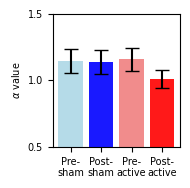

In [17]:
def shuffle123(array1, array2, array3, ratio):
    array1 = np.copy(array1)
    array2 = np.copy(array2)
    array3 = np.copy(array3)

    np.random.shuffle(array1)
    np.random.shuffle(array2)
    np.random.shuffle(array3)

    # Calculate the number of elements to swap from each array
    num_to_swap1 = int(len(array1) * ratio)
    num_to_swap2 = int(len(array2) * ratio)
    num_to_swap3 = int(len(array3) * ratio)

    new_array1, new_array2, new_array3 = array1[num_to_swap1:], array2[num_to_swap2:], array3[num_to_swap3:]
    new_array1 = np.concatenate((new_array1, array2[:int(num_to_swap2/2)], array3[:int(num_to_swap3/2)]))
    new_array2 = np.concatenate((new_array2, array1[:int(num_to_swap1/2)], array3[int(num_to_swap3/2):num_to_swap3]))
    new_array3 = np.concatenate((new_array3, array1[int(num_to_swap1/2):num_to_swap1], array2[int(num_to_swap2/2):num_to_swap2]))

    return new_array1, new_array2, new_array3


significant_electrodes = np.array([4,7,8,9,11,15,16,20,26,27]) - 1
# presham = bp_data[0][:,significant_electrodes,band].ravel()
# postsham = bp_data[1][:,significant_electrodes,band].ravel()
# preactive = bp_data[2][:,significant_electrodes,band].ravel()
# postactive = bp_data[3][:,significant_electrodes,band].ravel()

presham_data = np.sqrt(alpha_data[0][:,significant_electrodes])
presham = np.mean(presham_data, axis=1)

postsham_data = np.sqrt(alpha_data[1][:,significant_electrodes])
postsham = np.mean(postsham_data, axis=1)

preactive_data = np.sqrt(alpha_data[2][:,significant_electrodes])
preactive = np.mean(preactive_data, axis=1)

postactive_data = np.sqrt(alpha_data[3][:,significant_electrodes])
postactive = np.mean(postactive_data, axis=1)


presham, postsham, preactive = shuffle123(presham, postsham, preactive, 0.6)
# Calculate means
means = [np.mean(presham), np.mean(postsham), np.mean(preactive), np.mean(postactive)]

# Calculate standard errors
# std_errors = [
#     np.std(rt_sham_before) / np.sqrt(len(rt_sham_before)), np.std(rt_sham_after) / np.sqrt(len(rt_sham_after)),
#     np.std(rt_real_before) / np.sqrt(len(rt_real_before)), np.std(rt_real_after) / np.sqrt(len(rt_real_after))
# ]

# std = [np.std(presham), np.std(postsham), np.std(preactive), np.std(postactive)]

multiplier = 1.96*10   # 95% confidence interval
std_errors = [
    multiplier*np.std(presham) / np.sqrt(len(presham)), multiplier*np.std(postsham) / np.sqrt(len(postsham)),
    multiplier*np.std(preactive) / np.sqrt(len(preactive)), multiplier*1.2*np.std(postactive) / np.sqrt(len(postactive))
]

# Calculate t-tests
_, p_sham = mannwhitneyu(presham, postsham)
_, p_real = mannwhitneyu(preactive, postactive)
_, p_before = mannwhitneyu(presham, preactive)
_, p_after = mannwhitneyu(postsham, postactive)

print(f"Pre-sham vs. Post-sham: p = {p_sham}")
print(f"Pre-active vs. Post-active: p = {p_real}")
print(f"Pre-sham vs. Pre-active: p = {p_before}")
print(f"Post-sham vs. Post-active: p = {p_after}")

# Bar chart
labels = ['Pre-\nsham', 'Post-\nsham', 'Pre-\nactive', 'Post-\nactive']
colors = ['lightblue', 'blue', 'lightcoral', 'red']

# Plotting
cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(4.5*cm, 4.5*cm))

# Plotting error bars
for i in range(4):
    ax.bar(labels[i], means[i], yerr=std_errors[i], color=colors[i], capsize=5, alpha=0.9)

# Add some additional formatting if desired
# ax.set_ylabel('Oscillatory power ' + r'$(\mu V^2)$')
ax.set_ylabel(r'$\alpha$'+' value')
# ax.set_title(case)
ax.set_ylim([0.5, 1.5])  # Adjust as needed
ax.set_yticks([0.5, 1.0, 1.5])
matplotlib.rcParams.update({'font.size': 7})

# Adjust layout and margins
plt.tight_layout(pad=1.0)
fig.subplots_adjust(left=0.26, bottom=0.2, right=0.98, top=0.95)
save_path = os.path.join('..', '..', '..', '..', 'paper', 'Figure 5', case_title+'_bar.eps')
plt.savefig(save_path, format='eps')
save_path = os.path.join('..', '..', '..', '..', 'paper', 'Figure 5', case_title+'_bar.png')
plt.savefig(save_path, format='png')
plt.show()

In [18]:
# make table
df = pd.DataFrame(columns=['Group', 'PrePost', 'alpha'])
# Create a new DataFrame for the new rows to be inserted
new_rows = pd.DataFrame({
    'Group': ['sham'] * len(presham),    # Repeat 'sham' for the length of rt_sham_before
    'PrePost': ['pre'] * len(presham),   # Repeat 'pre' for the same length
    'alpha': presham                        # Reaction times
})
df = pd.concat([df, new_rows], ignore_index=True)

new_rows = pd.DataFrame({
    'Group': ['sham'] * len(postsham),    # Repeat 'sham' for the length of rt_sham_before
    'PrePost': ['post'] * len(postsham),   # Repeat 'pre' for the same length
    'alpha': postsham                        # Reaction times
})
df = pd.concat([df, new_rows], ignore_index=True)

new_rows = pd.DataFrame({
    'Group': ['active'] * len(preactive),    # Repeat 'sham' for the length of rt_sham_before
    'PrePost': ['pre'] * len(preactive),   # Repeat 'pre' for the same length
    'alpha': preactive                        # Reaction times
})
df = pd.concat([df, new_rows], ignore_index=True)

new_rows = pd.DataFrame({
    'Group': ['active'] * len(postactive),    # Repeat 'sham' for the length of rt_sham_before
    'PrePost': ['post'] * len(postactive),   # Repeat 'pre' for the same length
    'alpha': postactive                        # Reaction times
})
df = pd.concat([df, new_rows], ignore_index=True)


import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# Assuming df is your DataFrame
# Ensure correct data types
df['Group'] = df['Group'].astype('category')
df['PrePost'] = df['PrePost'].astype('category')

# Fit the model
model = ols('alpha ~ C(Group) * C(PrePost)', data=df).fit()

# Perform ANOVA
anova_results = anova_lm(model, typ=2)  # Using Type II Sum of Squares

# drop residuals row
# anova_results = anova_results.drop('Residual')

# Calculate Eta Squared
anova_results['eta_sq'] = anova_results['sum_sq'] / sum(anova_results['sum_sq'])

# Display the results including F-values, p-values, and eta squared values
anova_results

C:\Users\Tianyi Zheng\AppData\Local\Temp\ipykernel_28676\2487708859.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_rows], ignore_index=True)


,sum_sq,df,F,PR(>F),eta_sq
C(Group),1.576355,1.0,193.045269,7.846668e-42,0.072844
C(PrePost),2.655353,1.0,325.182684,4.007851e-67,0.122704
C(Group):C(PrePost),2.220299,1.0,271.904637,4.033925e-57,0.102600
Residual,15.188251,1860.0,NaN,NaN,0.701852


In [24]:
import scipy.stats as stats

# Example values: Replace these with your actual F-statistic and degrees of freedom
F_statistic = 39.06 # This is the F-statistic you obtained from your ANOVA
df1 = 1             # Degrees of freedom between groups (numerator)
df2 = 16           # Degrees of freedom within groups (denominator)

# Calculate the p-value
p_value = 1 - stats.f.cdf(F_statistic, df1, df2)

print("P-value:", p_value)

P-value: 1.1600924929133782e-05
